<a href="https://colab.research.google.com/github/katyk20/distance-education-highered/blob/main/Notebooks/TimeForecasting_ExpSmooth(Univariate).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Timeforecasting (Univariate)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://github.com/katyk20/distance-education-highered

Cloning into 'distance-education-highered'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 126 (delta 62), reused 20 (delta 7), pack-reused 0
Receiving objects: 100% (126/126), 2.27 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [4]:
%cd /content/distance-education-highered
!git pull

/content/distance-education-highered
Already up to date.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Processing IPEDS Distance Education enrollment data

In [ ]:
#function to process enrollment data

def process_enrollment_data(enrolled):
    # Filter for EFDELEV = 1 (Summary line for each institution)
    enrolled_sum = enrolled[enrolled['EFDELEV'] == 1]

    # Keep columns of interest for time forecasting
    cols_to_keep = ['UNITID', 'INSTNM', 'YEAR', 'EFDETOT', 'EFDEEXC', 'EFDESOM', 'EFDENON']
    enrolled_sum = enrolled_sum[cols_to_keep]

    # Remove rows where EFDEEXC == 0
    enrolled_sum = enrolled_sum[enrolled_sum['EFDEEXC'] != 0]

    # Group the data by 'UNITID' and count the number of unique years for each group
    unitid_year_counts = enrolled_sum.groupby('UNITID')['YEAR'].nunique()

    # Get the total number of unique years in the dataframe
    total_unique_years = enrolled_sum['YEAR'].nunique()

   # Filter 'UNITID's that have data for every year in the dataframe
    filtered_unitids = unitid_year_counts[unitid_year_counts == total_unique_years].index

    # Get institutions corresponding to the filtered 'UNITID's
    filtered_de = enrolled_sum[enrolled_sum['UNITID'].isin(filtered_unitids)]

    return filtered_de, filtered_de['INSTNM'].unique().tolist()




In [ ]:
#distance education enrollment data 2018-2022
enrolled_1822 = pd.read_csv('/content/drive/MyDrive/Capstone_Winter2024/PROJECT DATASETS/dist_enrollment18_22.csv')
filt_enroll_data_1822, institution_names = process_enrollment_data(enrolled_1822)

##Check shape and number of unique institutions:
# filt_enroll_data_1822.shape #(13015, 7)
# #number of unique institutions in dataset
# len(institution_names) #2748

In [ ]:
#Distance education enrollment data 2012-2022
enrolled_1222 = pd.read_csv('/content/drive/MyDrive/Capstone_Winter2024/PROJECT DATASETS/dist_enrollment12_22.csv')

filt_enroll_data_1222, institution_names2 = process_enrollment_data(enrolled_1222)

# Unclear to check shape and number of unique institutions:
# filt_enroll_data_1222.shape #(23023, 7)
# number of unique institutions in dataset
# len(institution_names2) #2381

Aggregate enrollment data

In [ ]:
#function to get aggregated enrollment by year across all institution and plot by type
def plot_aggregated_enrollment_data(enrollment_data):
    # Group by year and sum the enrollment data for each type
    agg_data = enrollment_data.groupby('YEAR')[['EFDEEXC', 'EFDESOM', 'EFDENON']].sum().reset_index()

    #get year range
    year_range = f"{agg_data['YEAR'].min()}-{agg_data['YEAR'].max()}"

    # Plotting
    sns.set_theme()
    sns.set_style("dark")
    fig, ax = plt.subplots()

    # Plot line plot
    ax = sns.lineplot(x='YEAR', y='value', hue='variable',
                      data=pd.melt(agg_data, ['YEAR']))

    # Set labels and title
    plt.xlabel('Year')
    plt.ylabel('Enrollment')
    plt.title('Aggregated Distance Education Enrollment by Type {}'.format (year_range))
    plt.legend()

    # Remove scientific notation, add commas on y-axis
    formatter = StrMethodFormatter('{x:,.0f}')
    plt.gca().yaxis.set_major_formatter(formatter)

    # Set x-axis to integer years
    plt.xticks(agg_data['YEAR'])

    plt.show()

    return agg_data, fig



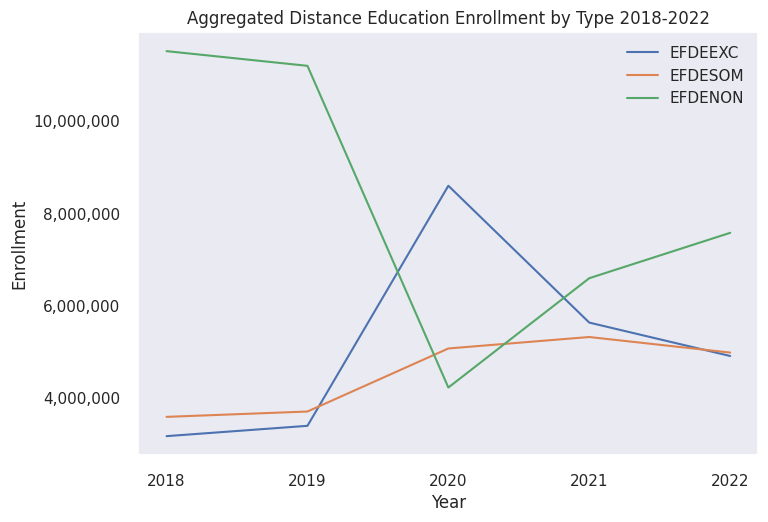

In [ ]:
#plot aggregated 2018-2022 distance education enrollment data by type
agg_data1822, fig = plot_aggregated_enrollment_data(filt_enroll_data_1822)

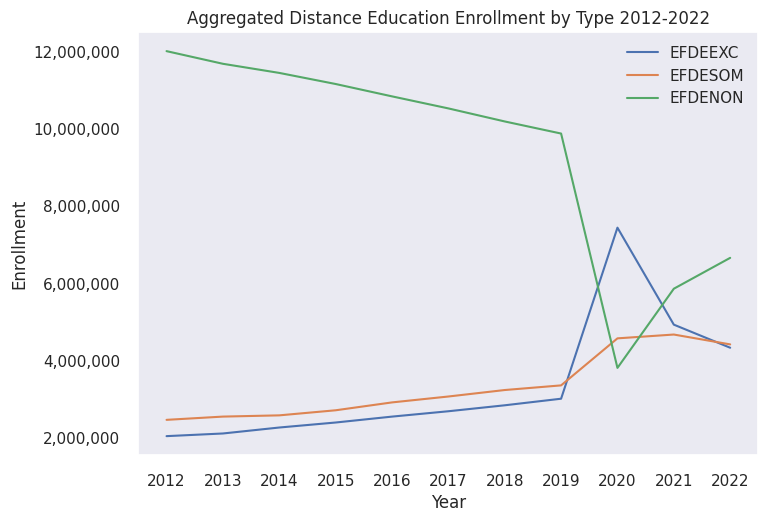

In [ ]:

agg_data1222, fig2 = plot_aggregated_enrollment_data(filt_enroll_data_1222)

Extract year and EFDEEXC for univariate timeseries forecasting

In [ ]:
def extract_data(data):
    data= data[['YEAR', 'EFDEEXC']]
    return data


data_exc = extract_data(agg_data1822)
data_exc2 = extract_data(agg_data1222)


#Time forecasting- Exponential Smoothing

In [ ]:
def exp_smooth(data, alpha=0.2):

    # Calculate fh_start and fh_end
    fh_start = data['YEAR'].max() + 1
    print(fh_start)
    fh_end = fh_start + len(data)
    print(fh_end)

    # Create instance of SES class
    ses = SimpleExpSmoothing(data['EFDEEXC'])

    # Fit model to data
    model = ses.fit(smoothing_level=alpha, optimized=False)



     # Forecast
    forecast_length = len(data)
    print(forecast_length)
    forecast = model.forecast(forecast_length)

    forecast_df = pd.DataFrame({
        'YEAR': range(fh_start, fh_end),
        'EFDEEXC_Forecast': forecast
    })

    # Calculate evaluation metrics
    mae = mean_absolute_error(data['EFDEEXC'], forecast_df['EFDEEXC_Forecast'])
    mse = mean_squared_error(data['EFDEEXC'], forecast_df['EFDEEXC_Forecast'])
    rmse = np.sqrt(mse)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Concatenate actual enrollment 18-22 and forecasted values
    combined_data = pd.concat([data, forecast_df], ignore_index=True)
    combined_data['EFDEEXC_Forecast'] = combined_data['EFDEEXC_Forecast'].map('{:.2f}'.format)

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}, combined_data, forecast_df


In [ ]:
#plot actual and forecasted results
def plot_enrollment_forecast(combined_data, forecast_df, year_range):
    plt.figure(figsize=(10, 6))

    # Plot actual enrollment
    plt.plot(combined_data['YEAR'], combined_data['EFDEEXC'], color='blue', label='Enrollment')

    # Highlight forecasted values
    plt.plot(forecast_df['YEAR'], forecast_df['EFDEEXC_Forecast'], linestyle='--', color='red', label='Forecasted Enrollment')

    # Get the index for the year 2022
    index_2022 = combined_data[combined_data['YEAR'] == 2022].index[0]

    # Plot a line connecting the actual and forecasted values at 2022
    plt.plot([combined_data['YEAR'].iloc[index_2022], forecast_df['YEAR'].iloc[0]],
             [combined_data['EFDEEXC'].iloc[index_2022], forecast_df['EFDEEXC_Forecast'].iloc[0]],
             linestyle='--', color='red')

    plt.xlabel('Year')
    plt.ylabel('Enrollment')
    plt.title('Actual vs. Forecasted Enrollment {}'.format(year_range))

    # # Set integer year ticks on the x-axis
    # plt.xticks(range(combined_data['YEAR'].min(), combined_data['YEAR'].max() + 1))


    # Remove scientific notation, add commas on y-axis
    formatter = StrMethodFormatter('{x:,.0f}')
    plt.gca().yaxis.set_major_formatter(formatter)


    plt.legend()
    plt.grid(False)
    plt.show()

2023
2028
5
Mean Absolute Error (MAE): 1590604.1033599996
Mean Squared Error (MSE): 4107392737314.677
Root Mean Squared Error (RMSE): 2026670.357338528


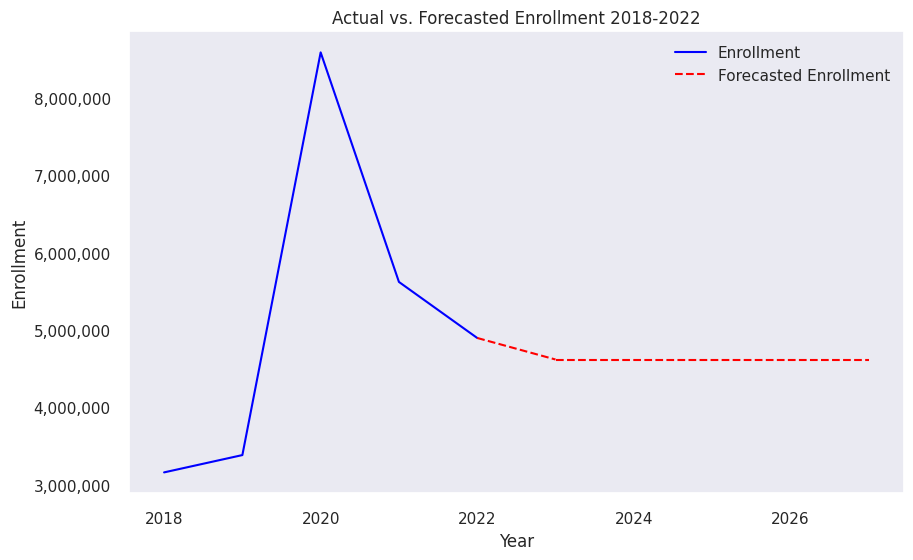

,YEAR,EFDEEXC,EFDEEXC_Forecast
0,2018,3159019.0,nan
1,2019,3382992.0,nan
2,2020,8593245.0,nan
3,2021,5623201.0,nan
4,2022,4898232.0,nan
5,2023,NaN,4619646.48
6,2024,NaN,4619646.48
7,2025,NaN,4619646.48
8,2026,NaN,4619646.48
9,2027,NaN,4619646.48


In [ ]:
# exp_smooth on 2018-2022 data

metrics, combined_data,forecast_df = exp_smooth(data_exc)
plot_enrollment_forecast(combined_data, forecast_df, '2018-2022')
combined_data

2023
2034
11
Mean Absolute Error (MAE): 1485065.592112454
Mean Squared Error (MSE): 2786241941790.7163
Root Mean Squared Error (RMSE): 1669203.9844760485


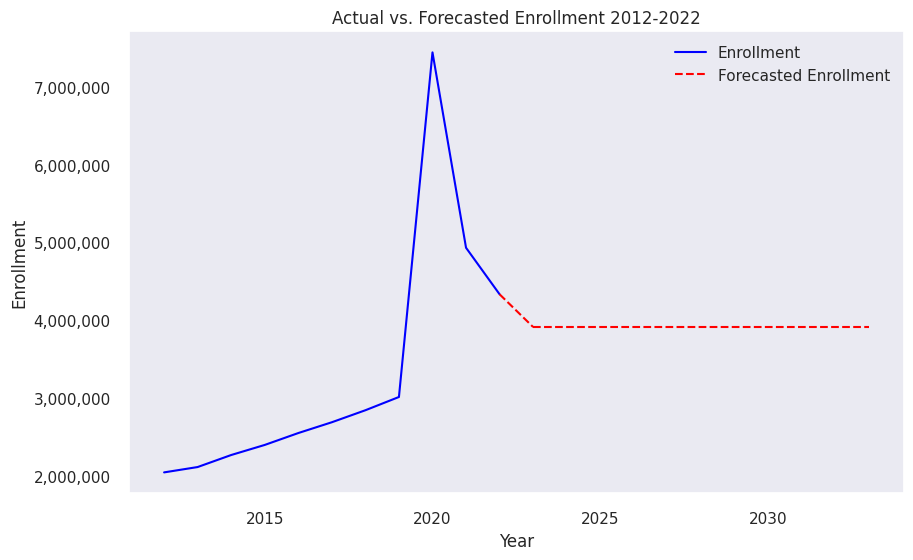

,YEAR,EFDEEXC,EFDEEXC_Forecast
0,2012,2048498.0,nan
1,2013,2117172.0,nan
2,2014,2271525.0,nan
3,2015,2400953.0,nan
4,2016,2553603.0,nan
5,2017,2692232.0,nan
6,2018,2846372.0,nan
7,2019,3016528.0,nan
8,2020,7440943.0,nan
9,2021,4932583.0,nan


In [ ]:
#exp_smooth on 2012-2022 data

metrics2, combined_data2, forecast_df2 = exp_smooth(data_exc2)
plot_enrollment_forecast(combined_data2, forecast_df2, '2012-2022')
combined_data2


Explore if 2020 data removed

2023
2027
4
Mean Absolute Error (MAE): 994855.5
Mean Squared Error (MSE): 1174642950744.8337
Root Mean Squared Error (RMSE): 1083809.4623801888


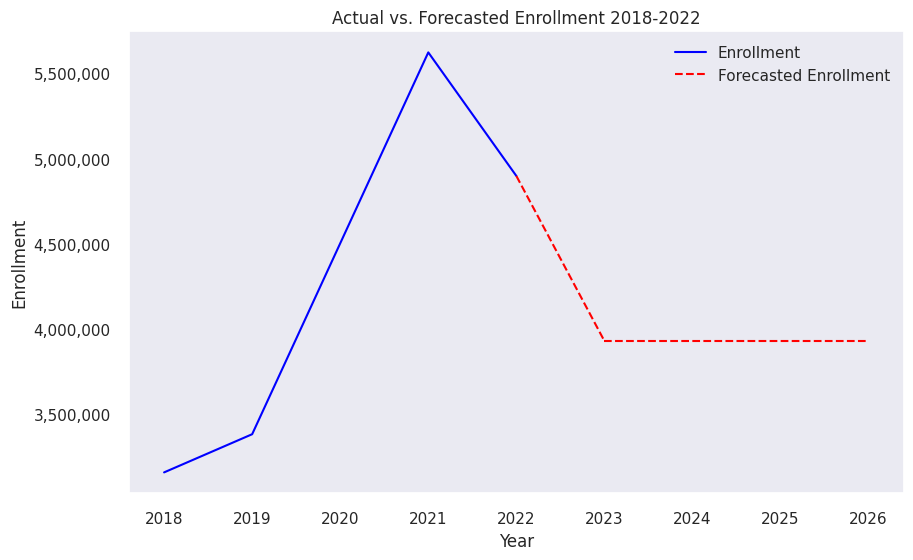

,YEAR,EFDEEXC,EFDEEXC_Forecast
0,2018,3159019.0,nan
1,2019,3382992.0,nan
2,2021,5623201.0,nan
3,2022,4898232.0,nan
4,2023,NaN,3929799.26
5,2024,NaN,3929799.26
6,2025,NaN,3929799.26
7,2026,NaN,3929799.26


In [ ]:
data1822_no20 = data_exc[data_exc['YEAR'] != 2020]

metrics1822_no20, combined_data1822_no20, forecast_df1822_no20 = exp_smooth(data1822_no20)
plot_enrollment_forecast(combined_data1822_no20, forecast_df1822_no20 , '2018-2022')
combined_data1822_no20

2023
2033
10
Mean Absolute Error (MAE): 905406.696985549
Mean Squared Error (MSE): 969785208772.7861
Root Mean Squared Error (RMSE): 984776.7304180101


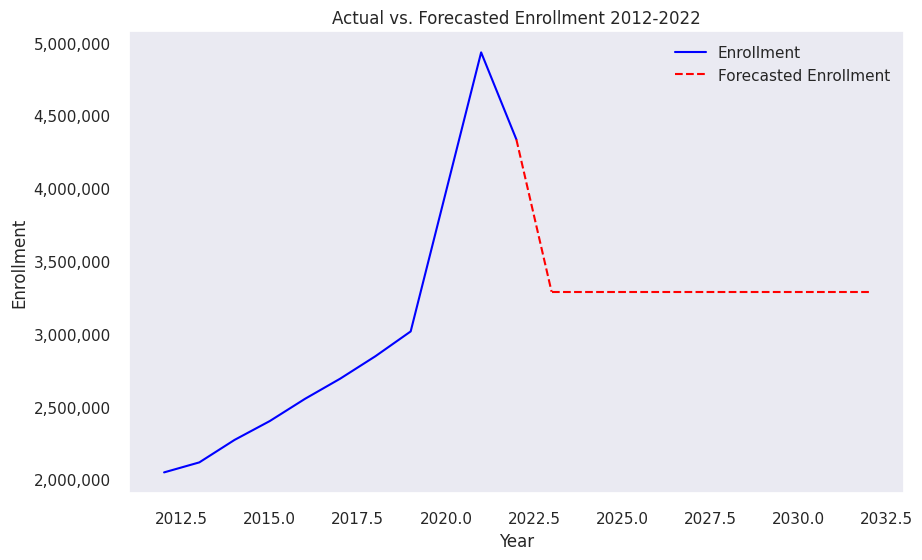

,YEAR,EFDEEXC,EFDEEXC_Forecast
0,2012,2048498.0,nan
1,2013,2117172.0,nan
2,2014,2271525.0,nan
3,2015,2400953.0,nan
4,2016,2553603.0,nan
5,2017,2692232.0,nan
6,2018,2846372.0,nan
7,2019,3016528.0,nan
8,2021,4932583.0,nan
9,2022,4335157.0,nan


In [ ]:
data1222_no20 = data_exc2[data_exc2['YEAR'] != 2020]

metrics1222_no20, combined_data1222_no20, forecast_df1222_no20 = exp_smooth(data1222_no20)
plot_enrollment_forecast(combined_data1222_no20, forecast_df1222_no20 , '2012-2022')
combined_data1222_no20